# Sarcasm Classification with 1D Convolutional Layer

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)
tf.enable_eager_execution()

1.14.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Getting the data

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2019-09-22 12:56:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.212.48, 2a00:1450:4017:801::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.212.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  3.84MB/s    in 1.4s    

2019-09-22 12:56:59 (3.84 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



## Tokenizing and data preprocessing

In [4]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [5]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Defining the bidirectional LSTM model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [8]:
with tf.device('/device:GPU:0'):
    history = model.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=1)

Train on 20000 samples, validate on 6709 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
20000/20000 [==============================] - 6s 304us/sample - loss: 0.4741 - acc: 0.7594 - val_loss: 0.4007 - val_acc: 0.8141
Epoch 2/10
20000/20000 [==============================] - 3s 165us/sample - loss: 0.3532 - acc: 0.8411 - val_loss: 0.4104 - val_acc: 0.8150
Epoch 3/10
20000/20000 [==============================] - 3s 165us/sample - loss: 0.3150 - acc: 0.8608 - val_loss: 0.4037 - val_acc: 0.8220
Epoch 4/10
20000/20000 [==============================] - 3s 166us/sample - loss: 0.2778 - acc: 0.8806 - val_loss: 0.4162 - val_acc: 0.8237
Epoch 5/10
20000/20000 [==============================] - 3s 165us/sample - loss: 0.2397 - acc: 0.9010 - val_loss: 0.4372 - val_acc: 0.8177
Epoch 6/10
20000/20000 [==============================] - 3s 164us/sample - loss: 0.2032 - acc: 0.9187 - val_loss: 0.4764 - val_acc: 0.8140
Epoch 7/10
20000/

## Visualizing the results

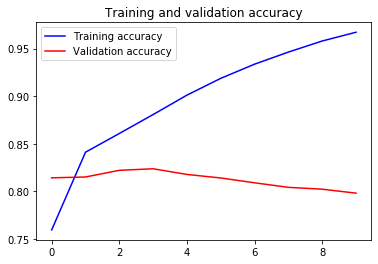

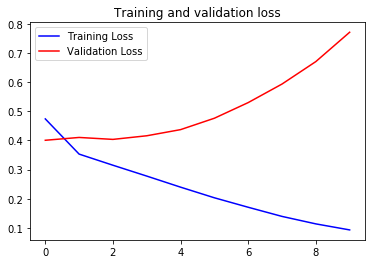

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()